In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('AudioWAV'):
    filenames.sort()
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[2]
        labels.append(label)
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,AudioWAV/1001_DFA_ANG_XX.wav,ANG
1,AudioWAV/1001_DFA_DIS_XX.wav,DIS
2,AudioWAV/1001_DFA_FEA_XX.wav,FEA
3,AudioWAV/1001_DFA_HAP_XX.wav,HAP
4,AudioWAV/1001_DFA_NEU_XX.wav,NEU


In [4]:
df['label'].value_counts()

label
ANG    1271
DIS    1271
FEA    1271
HAP    1271
SAD    1271
NEU    1087
Name: count, dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

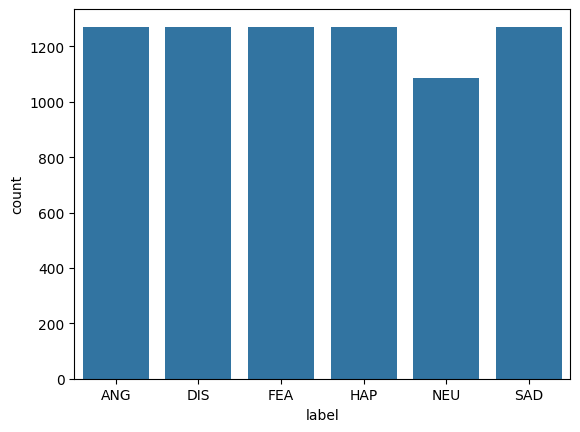

In [5]:
sns.countplot(data=df, x='label')

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

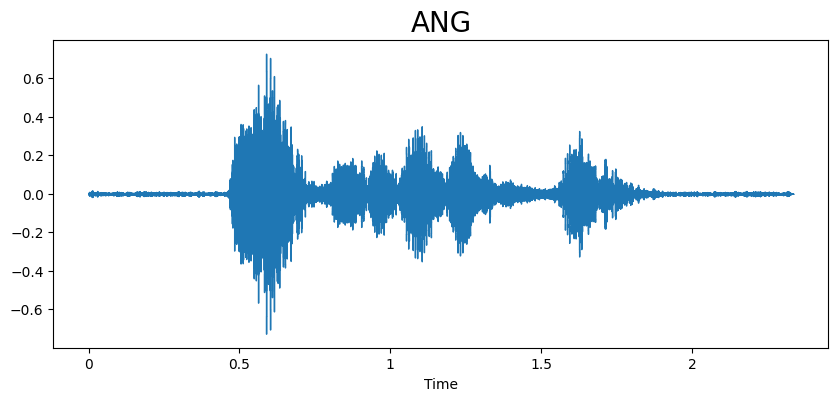

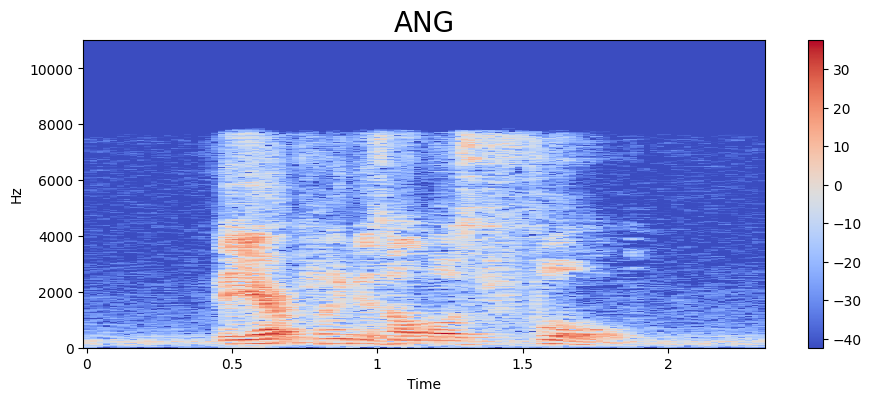

In [7]:
emotion = 'ANG'
path = np.array(df['speech'][df['label']==emotion])[10]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [8]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128).T
    return mfcc

In [9]:
mfcc=extract_mfcc(df['speech'][0])
print(mfcc.shape)

(40,)


# 1.一个简单的CNN_BiLSTM处理音频

In [1]:
from CNNBiLSTM_LoadData import load_data
from tensorflow.keras.utils import to_categorical
import numpy as np

data_batches = load_data('VideoFrameAudio-Simple-40')

audio_data = [item['audio'] for item in data_batches]
audio_data = np.array(audio_data).reshape(-1,10,128)
print(f"shape {audio_data.shape}")

categories = [item['category'] for item in data_batches]
categories = np.array(categories)
num_classes = len(np.unique(categories))
labels = to_categorical(categories, num_classes)

2024-01-05 02:03:02.691727: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 02:03:02.764209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 02:03:03.774190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


categories ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
start process Anger all imagefiles 2667 all audiofiles 2667
start process Disgust all imagefiles 2793 all audiofiles 2793
start process Fear all imagefiles 2369 all audiofiles 2369
start process Happy all imagefiles 2231 all audiofiles 2231
start process Neutral all imagefiles 2124 all audiofiles 2124
start process Sad all imagefiles 2511 all audiofiles 2511
process all files
shape (1467, 10, 128)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed, Activation,Dropout
import tensorflow as tf

# 定义模型参数
input_shape = (audio_data.shape[1],audio_data.shape[2])  # 输入数据的形状，不包括批次大小
# num_classes = 6         # 输出分类的数量

# 创建序贯模型
model = Sequential()

# 添加一个双向LSTM层
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.5))

# 可以添加更多的双向LSTM层，如果需要的话
model.add(Bidirectional(LSTM(128, return_sequences=True)))

# 添加一个双向LSTM层，但这次不返回序列，只返回最后的输出
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# 添加一个全连接层，它有num_classes个神经元
model.add(Dense(num_classes))

# 添加一个softmax激活层，用于分类
model.add(Activation('softmax'))

LR = 0.00005
opt = tf.keras.optimizers.legacy.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型概况
model.summary()

2024-01-04 22:53:10.511145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 830 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:31:00.0, compute capability: 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 256)           263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 10, 256)           394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [3]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_audio_epoch_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
audio_data_shuffle, labels_shuffle = shuffle(audio_data, labels, random_state=42) # random_state 参数确保了结果可以复现
history = model.fit(
    audio_data_shuffle, labels_shuffle, 
    epochs=500, 
    batch_size = 500,
    validation_split=0.5,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/500


2024-01-04 22:53:24.389555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-04 22:53:24.544915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/2 [==============>...............] - ETA: 7s - loss: 1.7995 - accuracy: 0.1780
Epoch 1: saving model to temp/CNNBiLSTM_audio_epoch_01.h5
2/2 [==============================] - 10s 2s/step - loss: 1.8026 - accuracy: 0.1678 - val_loss: 1.7929 - val_accuracy: 0.1526
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 1.7949 - accuracy: 0.1820

/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to temp/CNNBiLSTM_audio_epoch_02.h5
2/2 [==============================] - 0s 232ms/step - loss: 1.7923 - accuracy: 0.1869 - val_loss: 1.7880 - val_accuracy: 0.1635
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 1.7931 - accuracy: 0.1660
Epoch 3: saving model to temp/CNNBiLSTM_audio_epoch_03.h5
2/2 [==============================] - 0s 228ms/step - loss: 1.7913 - accuracy: 0.1664 - val_loss: 1.7863 - val_accuracy: 0.1853
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 1.7837 - accuracy: 0.2080
Epoch 4: saving model to temp/CNNBiLSTM_audio_epoch_04.h5
2/2 [==============================] - 0s 225ms/step - loss: 1.7825 - accuracy: 0.1978 - val_loss: 1.7865 - val_accuracy: 0.1826
Epoch 5/500
1/2 [==============>...............] - ETA: 0s - loss: 1.7758 - accuracy: 0.2200
Epoch 5: saving model to temp/CNNBiLSTM_audio_epoch_05.h5
2/2 [==============================] - 0s 232ms/step - loss: 1.7791 - accuracy: 0.2156 - val_loss: 1.

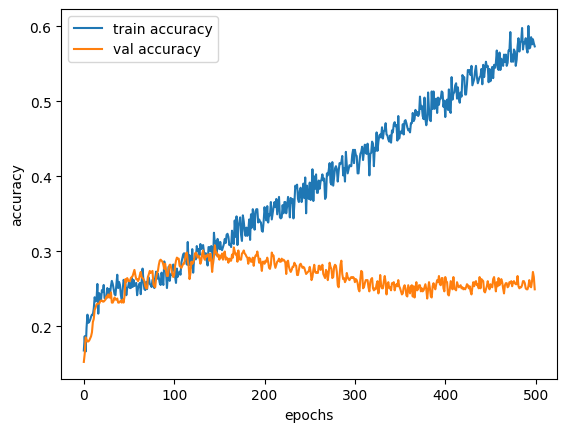

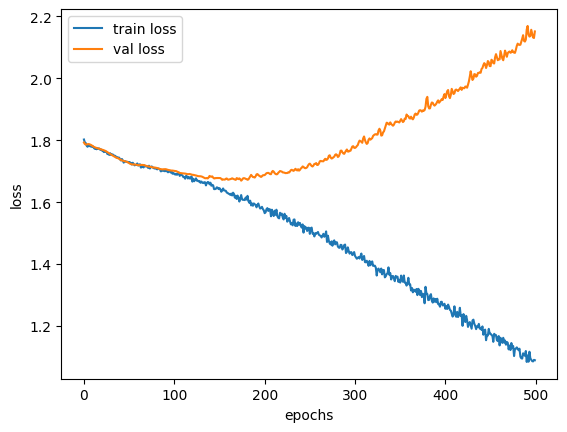

In [4]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,500)

# 2.使用ResNet18作为特征提取器

In [5]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Reshape
from tensorflow.keras.models import Model
from keras.optimizers import Adam

def resnet_1d_block(input_data, filters, kernel_size, stride):
    # 主路径
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # 残差连接
    shortcut = input_data
    if stride != 1 or input_data.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(input_data)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# 输入层
features = 128
input_shape = (features,)  # 特征数为500
inputs = Input(shape=input_shape)

# 重塑输入以适应Conv1D层的要求
reshaped_input = Reshape((features, 1))(inputs)
print(reshaped_input.shape)

# 初始卷积
x = Conv1D(64, kernel_size=7, strides=1, padding='same')(reshaped_input)
x = BatchNormalization()(x)
x = ReLU()(x)

# ResNet的残差块
x = resnet_1d_block(x, 64, kernel_size=3, stride=1)
x = resnet_1d_block(x, 64, kernel_size=3, stride=1)

x = resnet_1d_block(x, 128, kernel_size=3, stride=2)
x = resnet_1d_block(x, 128, kernel_size=3, stride=1)

x = resnet_1d_block(x, 256, kernel_size=3, stride=2)
x = resnet_1d_block(x, 256, kernel_size=3, stride=1)

x = resnet_1d_block(x, 512, kernel_size=3, stride=2)
x = resnet_1d_block(x, 512, kernel_size=3, stride=1)

# 结束层
x = GlobalAveragePooling1D()(x)
outputs = Dense(6, activation='softmax')(x)  # 根据类别数量调整

# 创建模型
model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# 打印模型结构
model.summary()

(None, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 128, 1)               0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 128, 64)              512       ['reshape[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 64)              256       ['conv1d[0][0]']              
 Normalization)                                                                

In [6]:
# 调整形状，适应新网络
print(audio_data.shape)
print(labels.shape)
X = audio_data.reshape(-1, audio_data.shape[-1])
y = np.repeat(labels, repeats=10, axis=0)
print(X.shape)
print(y.shape)

(1467, 10, 128)
(1467, 6)
(14670, 128)
(14670, 6)


In [7]:
# Train the model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_audio_resnet181d_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
X_shuffle, y_shuffle = shuffle(X, y, random_state=42) # random_state 参数确保了结果可以复现
history = model.fit(
    X_shuffle, y_shuffle ,
    epochs=50, 
    batch_size =200,
    # validation_data=(X_valid, y_test),
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/50


2024-01-04 22:56:09.283446: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x19580270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 22:56:09.283481: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-04 22:56:09.289539: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 22:56:09.472409: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-04 22:56:14.830354: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were avail

 1/59 [..............................] - ETA: 15:19 - loss: 2.0979 - accuracy: 0.1450

2024-01-04 22:56:18.616894: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


59/59 [==============================] - ETA: 0s - loss: 1.7591 - accuracy: 0.2432

2024-01-04 22:56:20.750061: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-04 22:56:20.849433: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: saving model to temp/CNNBiLSTM_audio_resnet181d_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 19s 61ms/step - loss: 1.7591 - accuracy: 0.2432 - val_loss: 2.4496 - val_accuracy: 0.1738
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 1.7065 - accuracy: 0.2629
Epoch 2: saving model to temp/CNNBiLSTM_audio_resnet181d_02.h5
59/59 [==============================] - 2s 35ms/step - loss: 1.7065 - accuracy: 0.2629 - val_loss: 2.7784 - val_accuracy: 0.1738
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 1.6974 - accuracy: 0.2679
Epoch 3: saving model to temp/CNNBiLSTM_audio_resnet181d_03.h5
59/59 [==============================] - 2s 42ms/step - loss: 1.6974 - accuracy: 0.2679 - val_loss: 2.8590 - val_accuracy: 0.1738
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 1.6886 - accuracy: 0.2716
Epoch 4: saving model to temp/CNNBiLSTM_audio_resnet181d_04.h5
59/59 [==============================] - 2s 41ms/step - loss: 1.6886 - accuracy: 0.2716 - val_loss: 2.5339 - val_accuracy: 0.1742
Epoch 5/

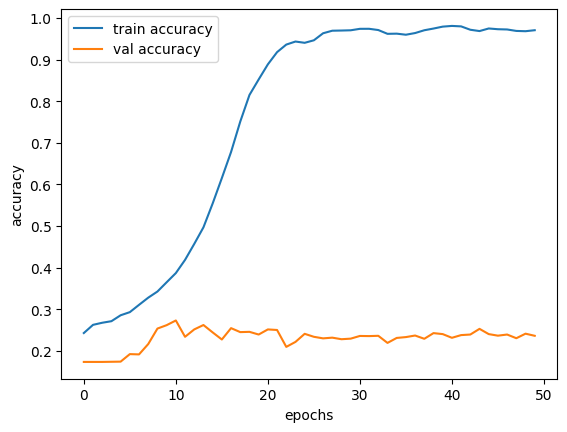

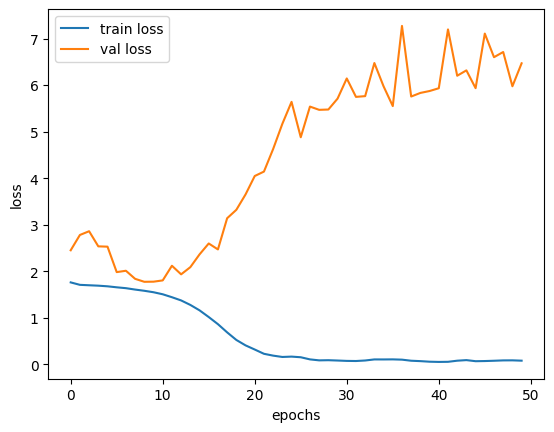

In [8]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,50)

# 3.加入BiLSTM

In [3]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Bidirectional, LSTM, Dense
import tensorflow as tf
from keras.optimizers import Adam

# 加载前面训练好的模型，精度为24.95%
pretrained_resnet18_model = tf.keras.models.load_model("temp/CNNBiLSTM_audio_resnet181d_11.h5")
resnet18_feature_extractor = Model(inputs=pretrained_resnet18_model.input, 
                                   outputs=pretrained_resnet18_model.layers[-2].output)
# 将特征提取器的所有层设置为不可训练的
for layer in resnet18_feature_extractor.layers:
    layer.trainable = False

time_steps, dims = 10, 128
input_shape = (time_steps, dims)
inputs = Input(shape=input_shape)
x = TimeDistributed(resnet18_feature_extractor,name='time_distributed_audio')(inputs)
x = Bidirectional(LSTM(units=128, return_sequences=False,dropout=0.1, recurrent_dropout=0.1))(x)
# x = Flatten()(x)
# x = GlobalAveragePooling1D()(x)
# outputs = x
# x = Dropout(0.1)(x)
outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 128)]         0         
                                                                 
 time_distributed_audio (Ti  (None, 10, 512)           3858304   
 meDistributed)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 4516230 (17.23 MB)
Trainable params: 657926 (2.51 MB)
Non-trainable params: 3858304 (14.72 MB)
_________________________________________________________________


In [5]:
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_audio_resnet181d_multiplex_epoch_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
audio_data_shuffle, labels_shuffle = shuffle(audio_data, labels, random_state=42) # random_state 参数确保了结果可以复现
history = model.fit(
    audio_data_shuffle, labels_shuffle, 
    epochs=150, 
    batch_size=32, 
    # validation_data=(x_val, y_val),
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/150


2024-01-05 02:06:07.184782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-05 02:06:07.617493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-05 02:06:07.728994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f18a0026b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 02:06:07.729026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-05 02:06:07.738004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-05 02:06:07.924890: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

33/33 [==============================] - ETA: 0s - loss: 1.6805 - accuracy: 0.2729
Epoch 1: saving model to temp/CNNBiLSTM_audio_resnet181d_multiplex_epoch_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 14s 180ms/step - loss: 1.6805 - accuracy: 0.2729 - val_loss: 1.6023 - val_accuracy: 0.3175
Epoch 2/150
33/33 [==============================] - ETA: 0s - loss: 1.6051 - accuracy: 0.3265
Epoch 2: saving model to temp/CNNBiLSTM_audio_resnet181d_multiplex_epoch_02.h5
33/33 [==============================] - 4s 115ms/step - loss: 1.6051 - accuracy: 0.3265 - val_loss: 1.5341 - val_accuracy: 0.3537
Epoch 3/150
33/33 [==============================] - ETA: 0s - loss: 1.5592 - accuracy: 0.3382
Epoch 3: saving model to temp/CNNBiLSTM_audio_resnet181d_multiplex_epoch_03.h5
33/33 [==============================] - 4s 119ms/step - loss: 1.5592 - accuracy: 0.3382 - val_loss: 1.4828 - val_accuracy: 0.3741
Epoch 4/150
33/33 [==============================] - ETA: 0s - loss: 1.4925 - accuracy: 0.3996
Epoch 4: saving model to temp/CNNBiLSTM_audio_resnet181d_multiplex_epoch_04.h5
33/33 [==============================] - 4s 115ms/step - loss: 1.4925 - accuracy: 0.

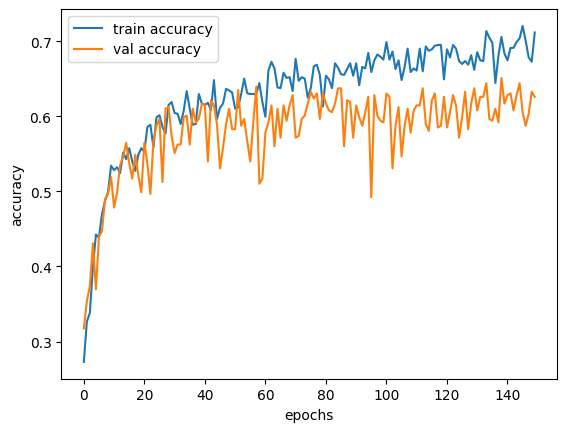

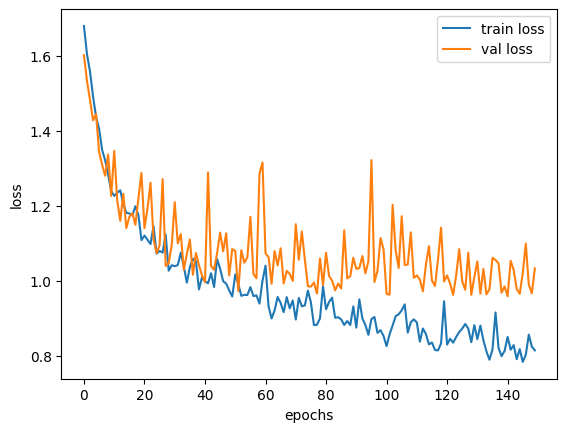

In [6]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,150)